# Location model

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import time

### CART model to predict location type

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [3]:
pick_data = pd.read_csv("THD Tracy DFC - Pick Locations.csv")

/Users/alessandroesciua/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,13,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
pick_data.head()

,ZONE,AISLE,BAY,LVL,LOCATION,LOCATION_TYPE,PERM / TEMP,LOC WIDTH,LOC LENGTH,LOC HEIGHT,CURR MIN,CURR MAX,SKU,DESCRIPTION,UNIT HEIGHT,UNIT WIDTH,UNIT LENGTH,UNIT WEIGHT,UNIT VOLUME,PACK FLAG,DAILY UNITS,DAILY CUBIC VELOCITY,DAILY HITS,WAVE TASK (4 WEEKS),LEAN TASK (4 WEEKS),TOTAL TASK (4 WEEKS),WEEK 1 UNITS (NEWEST),WEEK 2 UNITS,WEEK 3 UNITS,WEEK 4 UNITS (OLDEST),WEEKLY AVERAGE,ON-HAND INVENTORY,Weight > 35
0,BK1,10,45,NaN,BK1-010-045,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
1,BK1,10,46,NaN,BK1-010-046,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
2,BK1,10,47,NaN,BK1-010-047,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
3,BK1,10,48,NaN,BK1-010-048,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No
4,BK1,10,49,NaN,BK1-010-049,Bulk Floor,T,48.0,144.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,No


In [5]:
pick_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86393 entries, 0 to 86392
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ZONE                   86393 non-null  object 
 1   AISLE                  86393 non-null  object 
 2   BAY                    86393 non-null  int64  
 3   LVL                    84984 non-null  object 
 4   LOCATION               86393 non-null  object 
 5   LOCATION_TYPE          86213 non-null  object 
 6   PERM / TEMP            86393 non-null  object 
 7   LOC WIDTH              86393 non-null  float64
 8   LOC LENGTH             86393 non-null  float64
 9   LOC HEIGHT             86393 non-null  float64
 10  CURR MIN               13190 non-null  float64
 11  CURR MAX               13190 non-null  float64
 12  SKU                    13190 non-null  float64
 13  DESCRIPTION            13190 non-null  object 
 14  UNIT HEIGHT            13190 non-null  float64
 15  UN

In [6]:
pick_data.drop(['LOCATION_TYPE', 'AISLE', 'BAY','LVL', 'LOCATION', 'LOC WIDTH', 'LOC LENGTH', 'LOC HEIGHT', 
                'CURR MIN', 'CURR MAX', 'PACK FLAG', 'DAILY HITS', 'WAVE TASK (4 WEEKS)', 
               'LEAN TASK (4 WEEKS)', 'TOTAL TASK (4 WEEKS)', 'WEEK 1 UNITS (NEWEST)', 'WEEK 2 UNITS', 'WEEK 3 UNITS',
               'WEEK 4 UNITS (OLDEST)', 'WEEKLY AVERAGE',
               'ON-HAND INVENTORY'], axis=1, inplace = True)

In [7]:
pick_data = pick_data.set_index(['SKU', 'DESCRIPTION'])

In [8]:
pick_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 86393 entries, (nan, nan) to (nan, nan)
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ZONE                  86393 non-null  object 
 1   PERM / TEMP           86393 non-null  object 
 2   UNIT HEIGHT           13190 non-null  float64
 3   UNIT WIDTH            13190 non-null  float64
 4   UNIT LENGTH           13190 non-null  float64
 5   UNIT WEIGHT           13190 non-null  float64
 6   UNIT VOLUME           13190 non-null  float64
 7   DAILY UNITS           86393 non-null  float64
 8   DAILY CUBIC VELOCITY  86393 non-null  float64
 9   Weight > 35           86393 non-null  object 
dtypes: float64(7), object(3)
memory usage: 7.6+ MB


In [9]:
pick_data['PERM / TEMP'] = np.where(pick_data['PERM / TEMP'] == 'T', 1, 0)
pick_data['Weight > 35'] = np.where(pick_data['Weight > 35'] == 'Yes', 1, 0)
pick_data = pick_data.rename(columns={'PERM / TEMP': 'TEMP', 'Weight > 35': 'Heavy'})

In [10]:
#pick_data = pick_data.astype({'DESCRIPTION': 'string'}).dtypes

In [11]:
pick_data = pick_data.dropna()
pick_data.head()

,,ZONE,TEMP,UNIT HEIGHT,UNIT WIDTH,UNIT LENGTH,UNIT WEIGHT,UNIT VOLUME,DAILY UNITS,DAILY CUBIC VELOCITY,Heavy
SKU,DESCRIPTION,,,,,,,,,,
1.004698e+09,MINIBELTIS VICTORIAN WALL BLOCK,BK1,1,3.00,8.0,4.0,8.0,96.00,0.0,0.0,0
5.562110e+05,"12""X12"" GREY STEP STONE",BK1,1,1.88,12.0,12.0,20.0,270.72,0.0,0.0,0
9.151300e+05,"16"" X16"" RED BRICKFACE STEP STONE",BK1,1,1.88,16.0,16.0,31.1,481.28,0.0,0.0,0
5.408630e+05,"24""X24"" GRAY STEP STONE",BK1,1,2.00,24.0,24.0,88.0,1152.00,0.0,0.0,1
9.150680e+05,"12""X12"" RED STEP STONE",BK1,1,1.88,12.0,12.0,20.0,270.72,0.0,0.0,0


In [12]:
pick_train, pick_test = train_test_split(pick_data, test_size=0.2)

y_train = pick_train['ZONE']
X_train = pick_train.drop(columns = ['ZONE'])

y_test = pick_test['ZONE']
X_test = pick_test.drop(columns = ['ZONE'])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10552, 9) (10552,)
(2638, 9) (2638,)


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10552 entries, (1002780539.0, 'FNDTNS 38" NEO SHOWER ENCL- CHRM') to (1001834270.0, '7.2 AMP CORDED TOP-HANDLE JIG SAW KI')
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TEMP                  10552 non-null  int64  
 1   UNIT HEIGHT           10552 non-null  float64
 2   UNIT WIDTH            10552 non-null  float64
 3   UNIT LENGTH           10552 non-null  float64
 4   UNIT WEIGHT           10552 non-null  float64
 5   UNIT VOLUME           10552 non-null  float64
 6   DAILY UNITS           10552 non-null  float64
 7   DAILY CUBIC VELOCITY  10552 non-null  float64
 8   Heavy                 10552 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.5+ MB


In [14]:
y_train.head()

SKU           DESCRIPTION                      
1.002781e+09  FNDTNS 38" NEO SHOWER ENCL- CHRM     SR2
4.628280e+05  3D 1-1/4" BRIGHT BOX 1 LB            CP1
1.003370e+09  MEN'S BLACK FLEECE LINED KNIT HAT    CP1
1.004708e+09  STANLEY MITER BOX                    CP2
1.004106e+09  BOOTZCAST 5 FT. RH TUB WHITE         BK1
Name: ZONE, dtype: object

In [15]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

            
dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=0) # default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc.fit(X_train, y_train)

/Users/alessandroesciua/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.0e+00, 1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05,
       7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04,
       1.4e-04, 1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04,
       2.1e-04, 2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04,
       2.8e-04, 2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3...
       7.0e-04, 7.1e-04, 7.2e-04, 7.3e-04, 7.4e-04, 7.5e-04, 7.6e-04,
       7.7e-04, 7.8e-04, 7.9e-04, 8.0e-04, 8.1e-04, 8.2e-04, 8.3e-04,
       8.4e-04, 8.5e-04, 8.6e-04, 8.7e-04, 8.8e-04, 8.9e-04, 9.0e-04,
       9.1e-04, 9.2e-04, 9.3e-04, 9.4e-04, 9.5e-04, 9.6e-04, 9.7e-04,
       9.8e-04, 9.9e-04, 1.0e-03]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy')

In [16]:
# Pull best ccp_alpha score via best_params
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])

# Pull accuracy of CART model on test set using best_params
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

# Note predicting zone instead of location type to compare with Miami data

Grid best parameter ccp_alpha (max. accuracy):  0.0007700000000000001
Grid best score (accuracy):  0.59694994973431


Feature: 0, Score: 0.06951
Feature: 1, Score: 0.14833
Feature: 2, Score: 0.12209
Feature: 3, Score: 0.12874
Feature: 4, Score: 0.17619
Feature: 5, Score: 0.31850
Feature: 6, Score: 0.01056
Feature: 7, Score: 0.02372
Feature: 8, Score: 0.00236


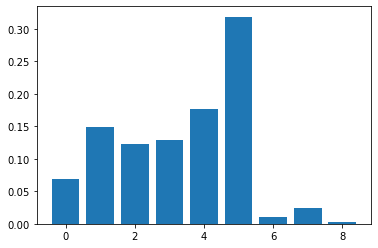

In [17]:
from matplotlib import pyplot
dtc.fit(X_train, y_train)
importance = dtc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [18]:
miami_data = pd.read_csv("2022-02-28_Miami Profiling v2.csv")

In [19]:
miami_data.head()

,SKU,Description,Department,Class Name,Sub Class Name,dimx,dimy,dimz,weight,Unnamed: 9,Class,Conveyable Results,NSST Results,Override,Result,Zone,Daily Units,Daily Hits,Daily Cube,Slots,SKU.1,Min,Max,Heavy,Liquid,Ship-Ready,Bulk Locations,Desired Profile,Module,Slots.1,SKU.2,Min.1,Max.1,SKU Volume,Recalculated Max,Assigned Slot
0,215583,GLAC BAY WHT DUALFLSH TOILET 2PC,029B,32 - TOILETS & SEATS,7 - TOILETS,31.80,27.500,17.900,99.00,27.50,DFS,NC,BULK (Clamp),NaN,BULK (Clamp),BK3,7.342466,2.032877,66.513689,FALSE,215583,14.684932,See Con,N,NaN,N,20,IGNORE,IGNORE,IGNORE,215583,IGNORE,IGNORE,IGNORE,IGNORE,NaN
1,1003572066,70 PD 6068 LOW-E SC IMPACT,30,28 - PATIO DOORS,8 - VINYL PATIO DOORS,6.50,82.000,76.000,180.00,76.00,DFS,NC,BULK (PJ),NaN,BULK (PJ),BK1,2.539726,1.194521,59.536587,FALSE,1003572066,5.079452,See Con,N,NaN,N,18,IGNORE,IGNORE,IGNORE,1003572066,IGNORE,IGNORE,IGNORE,IGNORE,NaN
2,1002961068,STEEL FOLDING CHAIR - BEIGE,059S,7 - ORGANIZATION,17 - TABLE AND CHAIRS,19.25,16.125,38.875,77.04,19.25,DFS,NC,BULK (Clamp),NaN,BULK (Clamp),BK3,6.060274,0.076712,42.320363,FALSE,1002961068,12.120548,See Con,N,NaN,N,13,IGNORE,IGNORE,IGNORE,1002961068,IGNORE,IGNORE,IGNORE,IGNORE,NaN
3,328448,ALEX PAINTERS WHITE 10.1 OZ,24,2 - CAULKS,2 - LATEX,48.00,46.000,40.000,1702.00,46.00,DFS,NC,BULK (PJ),NaN,BULK (PJ),BK1,0.797260,0.019178,40.748858,FALSE,328448,30.000000,See Con,N,NaN,N,12,IGNORE,IGNORE,IGNORE,328448,IGNORE,IGNORE,IGNORE,IGNORE,NaN
4,686826,GB ELONGATED ALL-IN-ONE HET IN WHITE,029B,32 - TOILETS & SEATS,7 - TOILETS,31.69,27.870,17.010,99.50,27.87,DFS,NC,BULK (Clamp),NaN,BULK (Clamp),BK3,4.049315,0.808219,35.204757,FALSE,686826,8.098630,See Con,N,NaN,N,11,IGNORE,IGNORE,IGNORE,686826,IGNORE,IGNORE,IGNORE,IGNORE,NaN


In [20]:
miami_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SKU                 6844 non-null   int64  
 1   Description         6844 non-null   object 
 2   Department          6844 non-null   object 
 3   Class Name          6844 non-null   object 
 4   Sub Class Name      6844 non-null   object 
 5   dimx                6844 non-null   float64
 6   dimy                6844 non-null   float64
 7   dimz                6844 non-null   float64
 8   weight              6844 non-null   float64
 9   Unnamed: 9          6844 non-null   float64
 10  Class               6844 non-null   object 
 11  Conveyable Results  6844 non-null   object 
 12  NSST Results        6844 non-null   object 
 13  Override            1166 non-null   object 
 14  Result              6844 non-null   object 
 15  Zone                6844 non-null   object 
 16  Daily 

In [21]:
miami_data = miami_data.set_index(['SKU', 'Description'])  
miami_data['Heavy'] = np.where(miami_data['Heavy'] == 'N', 0, 1)
miami_data.drop(['Department', 'Class Name', 'Sub Class Name','Unnamed: 9', 'Class', 'Conveyable Results',
                    'NSST Results', 'Override', 'Slots', 'SKU.1', 'Min', 'Max', 'Liquid', 'Ship-Ready', 
                    'Bulk Locations', 'Desired Profile', 'Module', 'Slots.1', 'SKU.2', 'Min.1', 'Max.1', 'SKU Volume',
                     'Recalculated Max', 'Assigned Slot', 'Daily Units', 'Daily Hits', 'Daily Cube', 'Result'], axis=1, inplace = True)
miami_data.head()

,,dimx,dimy,dimz,weight,Zone,Heavy
SKU,Description,,,,,,
215583,GLAC BAY WHT DUALFLSH TOILET 2PC,31.80,27.500,17.900,99.00,BK3,0
1003572066,70 PD 6068 LOW-E SC IMPACT,6.50,82.000,76.000,180.00,BK1,0
1002961068,STEEL FOLDING CHAIR - BEIGE,19.25,16.125,38.875,77.04,BK3,0
328448,ALEX PAINTERS WHITE 10.1 OZ,48.00,46.000,40.000,1702.00,BK1,0
686826,GB ELONGATED ALL-IN-ONE HET IN WHITE,31.69,27.870,17.010,99.50,BK3,0


In [22]:
miami_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6844 entries, (215583, 'GLAC BAY WHT DUALFLSH TOILET 2PC') to (655414, 'HEX NUT ZINC 1/4 (AAB)')
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dimx    6844 non-null   float64
 1   dimy    6844 non-null   float64
 2   dimz    6844 non-null   float64
 3   weight  6844 non-null   float64
 4   Zone    6844 non-null   object 
 5   Heavy   6844 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 970.0+ KB


In [23]:
miami_data = miami_data.dropna()
miami_train, miami_test = train_test_split(miami_data, test_size=0.2)

y_train_miami = miami_train['Zone']
X_train_miami = miami_train.drop(columns = ['Zone'])

y_test_miami = miami_test['Zone']
X_test_miami = miami_test.drop(columns = ['Zone'])

print(X_train_miami.shape, y_train_miami.shape)
print(X_test_miami.shape, y_test_miami.shape)

(5475, 5) (5475,)
(1369, 5) (1369,)


In [24]:
grid_values = {'ccp_alpha': np.linspace(0, 0.001, 101),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'random_state': [88]}

            
dtc_miami = DecisionTreeClassifier()
dtc_cv_acc_miami = GridSearchCV(dtc_miami, param_grid = grid_values, scoring = 'accuracy', cv=10, verbose=0) # default scoring metric to optimize is accuracy, used as default if none given.
dtc_cv_acc_miami.fit(X_train_miami, y_train_miami)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.0e+00, 1.0e-05, 2.0e-05, 3.0e-05, 4.0e-05, 5.0e-05, 6.0e-05,
       7.0e-05, 8.0e-05, 9.0e-05, 1.0e-04, 1.1e-04, 1.2e-04, 1.3e-04,
       1.4e-04, 1.5e-04, 1.6e-04, 1.7e-04, 1.8e-04, 1.9e-04, 2.0e-04,
       2.1e-04, 2.2e-04, 2.3e-04, 2.4e-04, 2.5e-04, 2.6e-04, 2.7e-04,
       2.8e-04, 2.9e-04, 3.0e-04, 3.1e-04, 3.2e-04, 3...
       7.0e-04, 7.1e-04, 7.2e-04, 7.3e-04, 7.4e-04, 7.5e-04, 7.6e-04,
       7.7e-04, 7.8e-04, 7.9e-04, 8.0e-04, 8.1e-04, 8.2e-04, 8.3e-04,
       8.4e-04, 8.5e-04, 8.6e-04, 8.7e-04, 8.8e-04, 8.9e-04, 9.0e-04,
       9.1e-04, 9.2e-04, 9.3e-04, 9.4e-04, 9.5e-04, 9.6e-04, 9.7e-04,
       9.8e-04, 9.9e-04, 1.0e-03]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy')

In [25]:
# Pull best ccp_alpha score via best_params
print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc_miami.best_params_['ccp_alpha'])

# Pull accuracy of CART model on test set using best_params
print('Grid best score (accuracy): ', dtc_cv_acc_miami.best_score_)

# Note predicting zone instead of location type as it was unavailable

Grid best parameter ccp_alpha (max. accuracy):  0.0005600000000000001
Grid best score (accuracy):  0.5623620544709698
